In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #default 'last_expr'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer

# Import usual data analysis tools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#np.random.seed(2018)

import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

In [3]:
from helpers import path_pdf,path_pkl,plot_freq_dist,get_top_n_words,plot_words_freq

## II. Loading in and filtering the data

The datafile we use for this analysis is a pickle file containing processed versions of PERC papers from 2001 to 2018. We have scraped the available PDFs, then done the following data cleaning on the scraped text:
1. Removed references, acknowledgments, keywords, and PACS 
2. Removed all numbers, symbols, punctuation, characters, and section headers
3. Removed "stop words" (words like "and", "or", "is", etc. which do not carry specific meaning)
4. Lowercased all words
5. Lemmatized all words, reducing them to their more basic form (for example, reducing "tests", "testing", and "tested" to "test")
6. Created bi-grams: combining commonly-associated words into one (for example, "problem" and "solving" into "problem_solving")
7. Turned the resulting text into a list of individual words, or "tokens"

This processed data was then stored in a datafile, which we now load in:

In [4]:
data_words_bigrams = pd.read_pickle(path_pkl+'scied_words_bigrams_V5.pkl')

### A. Plotting top words in all documents

Now, we will do some investigation and filtering based on word frequency. Our goal is to filter out the words that occur in a large number of documents, which are less likely to carry any distinct meaning for any specific theories, methods, or research traditions in PER. For example, most people in the PER community talk about "physics", "education", and "students" in one form or another. Those words do not carry much meaning, and so should be removed from our dataset in order to make sure that the more interesting, distinct, and meaningful words are prioritized in the analysis.

We start by defining and implementing some functions to plot the word frequency distribution in the dataset.

In [5]:
corpus = [ w for doc in data_words_bigrams for w in doc ]
print('Total words: \033[1m%d\033[0m, unique words: \033[1m%d\033[0m' % (len(corpus), len(set(corpus))))


Total words: 11673326, unique words: 200776


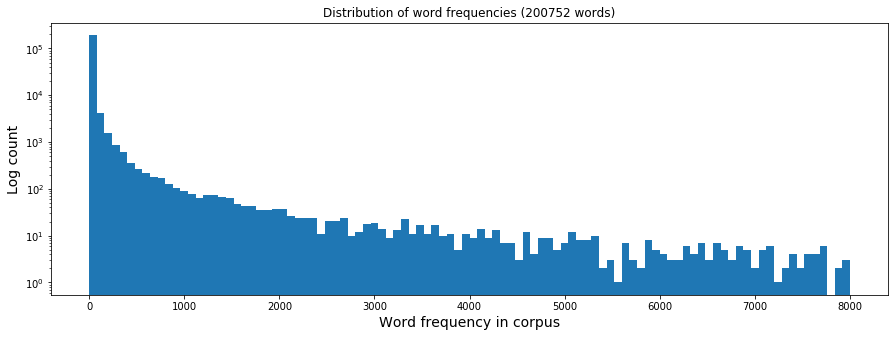

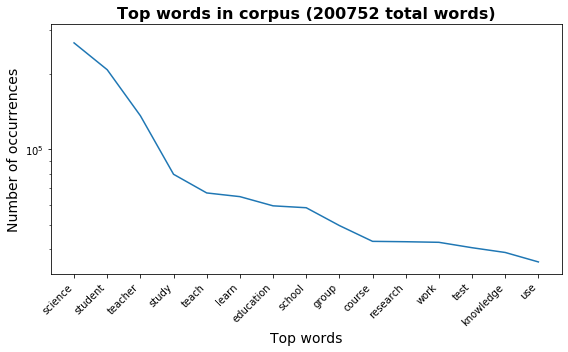

In [6]:
[words, freq, ids] = get_top_n_words(corpus, n_top_words=None)
fig = plot_freq_dist(freq, range=[0,8000])
fig, ax = plot_words_freq(words, freq, 15)

### B. Creating a Bag of Words to filter the dataset

Thankfully, Gensim already has a built-in function to do this kind of filtering, "filter_extremes", which allows us to filter out words that appear too many or too few times. The parameters are:
* **no_below**: an integer. Keep tokens which are contained in at least no_below documents.  
* **no_above**: a float number between 0 and 1. It filters out tokens which are contained in more than no_above percentage of documents. E.g. with no_above=0.5, tokens in in more than 50% of the documents get cut out.  
* **keep_n**: an integer. It specifies how many tokens should be kept, starting with the most frequent.

However, to use this function we must first create a [Gensim Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary), which is a mapping between each of the entries (i.e. normalized words) and its integer id in the corpus. 

Based on repeated runs with different filtering values, we've set the no_above parameter to 0.55, which filters out 103 words (displayed below). We have also tried out a variety of no_below values, and have found that no_below 15 gives us more coherent topics. With the filter set to 15, we remove a large amount of the dataset (roughly 24,300 words). However, our primary goal is to find themes and topics that have been prevalent across the PER community over time, and because none of these words occurs in more than 15 documents (out of ~1300), we feel that they are unlikely to add a lot of meaning to the analysis.

After the filtering we convert the remaining tokens into a "bag of words" (BoW).

In [7]:
no_below = 15
no_above = 0.75
import copy
id2word_unfiltered_above = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
id2word_unfiltered_above.filter_extremes(no_below=no_below, no_above=1, keep_n=100000)
print("Dictionary with \033[1mno_above=1\033[0m contains \033[1m%d\033[0m unique words\n" % (len(id2word_unfiltered_above)))

id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)

#Effect of using no_above
diff_set = set(list(id2word_unfiltered_above.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))

no_above = 0.65
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))

no_above = 0.6
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))

no_above = 0.55
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))



no_above = 0.5
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))

no_above = 0.45
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))


no_above = 0.4
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))


no_above = 0.35
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))


no_above = 0.3
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))

no_above = 0.25
id2word_prev = copy.deepcopy(id2word)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))


del id2word_prev

Dictionary with no_above=1 contains 25073 unique words

Dictionary filtered with no_above=0.75 contains 25053 unique words. 20 words removed:
 ['education', 'follow', 'give', 'group', 'include', 'learn', 'need', 'present', 'problem', 'result', 'school', 'science', 'student', 'study', 'teach', 'teacher', 'time', 'use', 'way', 'work'] 

Dictionary filtered with no_above=0.65 contains 25025 unique words. 28 words removed:
 ['base', 'change', 'class', 'course', 'different', 'experience', 'fact', 'form', 'general', 'great', 'high', 'important', 'individual', 'know', 'knowledge', 'level', 'material', 'mean', 'method', 'new', 'number', 'point', 'provide', 'question', 'research', 'state', 'understand', 'year'] 

Dictionary filtered with no_above=0.60 contains 24996 unique words. 29 words removed:
 ['activity', 'area', 'begin', 'case', 'come', 'consider', 'develop', 'development', 'example', 'help', 'ing', 'make', 'nature', 'order', 'place', 'possible', 'process', 'program', 'purpose', 'report'